# Classifiers

In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_mldata
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

## Load the MNIST data

The server that Scikit Learn pulled this data from does not seem to exist anymore. The data was found from an alternate source then placed in the directory where Scikit would usually cache data sets.

In [2]:
mnist = fetch_mldata('MNIST original')
X, y = mnist["data"], mnist["target"]

In [3]:
print(mnist["DESCR"])
print(X.shape, y.shape)

mldata.org dataset: mnist-original
(70000, 784) (70000,)


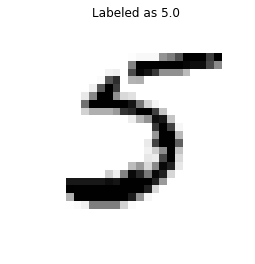

In [4]:
i = np.random.randint(60000)

some_digit = X[i]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.title(f"Labeled as {y[i]}")

plt.show()

In [5]:
XTrain, XTest, yTrain, yTest = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
shuffleIndeces = np.random.permutation(60000)
XTrain, yTrain = XTrain[shuffleIndeces], yTrain[shuffleIndeces]

In [7]:
pipe = Pipeline([ ('normalizer', MinMaxScaler()) ])
prepTrain = pipe.fit_transform( XTrain.astype(np.float64) )

In [8]:
params = { "weights" : ["uniform", "distance"],
           "n_neighbors": [ 3, 4, 5, 6, 7 ] }

knn = KNeighborsClassifier()

gridKNN = GridSearchCV( knn, params, cv = 3, verbose = 3, n_jobs = 3 )
gridKNN.fit(prepTrain, yTrain)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=uniform, score=0.9709485474273714, total=37.0min
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.9684563087382524, total=37.1min
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=uniform, score=0.9674065186962607, total=37.4min
[CV] n_neighbors=4, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.9688953343001451, total=38.6min
[CV] n_neighbors=4, weights=uniform ..................................
[CV]  n_neighbors=3, weights=distance, score=0.97019552932

[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 841.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [9]:
gridKNN.best_score_

0.9718

In [10]:
gridKNN.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [9]:
gridKNN = KNeighborsClassifier( n_neighbors = 4, weights = 'distance' )
gridKNN.fit( prepTrain, yTrain )

pred = gridKNN.predict(pipe.transform( XTest.astype(np.float64)) )
accuracy_score(yTest, pred)

0.9714

## Shift the images by one pixel

In [10]:
def shiftImages( X, y ):
    """Augments the data by adding copies of each image shifted one pixel
       in each direction. Returns new shuffled arrays."""

    m, n = X.shape

    tmp = X.reshape( (m, int(np.sqrt(n)), int(np.sqrt(n)) ) )

    newX = np.zeros( shape = (5*m, n ) )
    newY = np.zeros( 5*m )

    newX[ : m] = X[:]
    newY[ : m] = y[:]
    newX[m : 2*m] = np.roll(tmp, 1, 1).reshape(m,n)[:]
    newY[m : 2*m] = y[:]
    newX[2*m : 3*m] = np.roll(tmp, 1, 1).reshape(m,n)[:]
    newY[2*m : 3*m] = y[:]
    newX[3*m : 4*m] = np.roll(tmp, -1, 2).reshape(m,n)[:]
    newY[3*m : 4*m] = y[:]
    newX[4*m : 5*m] = np.roll(tmp, -1, 2).reshape(m,n)[:]
    newY[4*m : 5*m] = y[:]

    shuffleIndeces = np.random.permutation( len(newX) )

    return newX[shuffleIndeces], newY[shuffleIndeces]


In [11]:
prepTrain, yTrain = shiftImages( prepTrain, yTrain )

#knn = KNeighborsClassifier( **gridKNN.best_params_ )
knn = KNeighborsClassifier( n_neighbors = 4, weights = 'distance' )
knn.fit( prepTrain, yTrain )

pred = knn.predict( pipe.transform( XTest.astype(np.float64)) )
accuracy_score(yTest, pred)

0.9705